In [19]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model,Sequential, save_model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tensorflow.keras.losses import *
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from tensorflow.keras.regularizers import l1_l2
from tensorflow.python.client import device_lib
import numpy as np
import joblib
from matplotlib import cm as CM
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import scipy.io as io
from PIL import Image
import PIL
import h5py
import os
import glob
import cv2
import random
import math
import sys
import itertools 

print(tf.__version__)

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s\n\n' % policy.variable_dtype)

for info in device_lib.list_local_devices():
    if (info.name.find('GPU') != -1):
        print(info)

2.5.0
Compute dtype: float16
Variable dtype: float32




In [20]:
print(tf.__version__)

2.5.0


# Load Ground Truth

In [21]:
def getPath(data_type):
    root = r'Shanghai Dataset/ShanghaiTech'
    print(root)
    if data_type.find('part_A')!=-1:
        target_train = os.path.join(root,r'part_A/train_data','images')
        target_test = os.path.join(root,r'part_A/test_data','images')

    elif data_type.find('part_B')!=-1:
        target_train = os.path.join(root,r'part_B/train_data','images')
        target_test = os.path.join(root,r'part_B/test_data','images')

    train_path = []
    for img_path in glob.glob(os.path.join(target_train, '*.jpg')):
        train_path.append(str(img_path))
        
    test_path = []
    for img_path in glob.glob(os.path.join(target_test, '*.jpg')):
        test_path.append(str(img_path))
        
    return train_path, test_path

def load_density(file_path):
    gt_file = h5py.File(file_path, 'r')
    groundtruth = np.asarray(gt_file['density'])
    groundtruth = np.expand_dims(groundtruth, axis=-1)
    return groundtruth

# Get input image path
train_paths, test_paths = getPath('part_B')
# Get ground truth path
gth_train = [path.replace('jpg', 'h5').replace('images', 'ground-truth-h5') for path in train_paths]
gth_test = [path.replace('jpg', 'h5').replace('images', 'ground-truth-h5') for path in test_paths]

print('train len:', len(train_paths))
print('test len:', len(test_paths))

print(train_paths[0])
print(gth_train[0])

train_labels=np.array([load_density(path) for path in gth_train]).astype('float16')
print(train_labels.shape)
test_labels=np.array([load_density(path) for path in gth_test]).astype('float16')
print(test_labels.shape)

Shanghai Dataset/ShanghaiTech
train len: 400
test len: 316
Shanghai Dataset/ShanghaiTech\part_B/train_data\images\IMG_1.jpg
Shanghai Dataset/ShanghaiTech\part_B/train_data\ground-truth-h5\IMG_1.h5
(400, 768, 1024, 1)
(316, 768, 1024, 1)


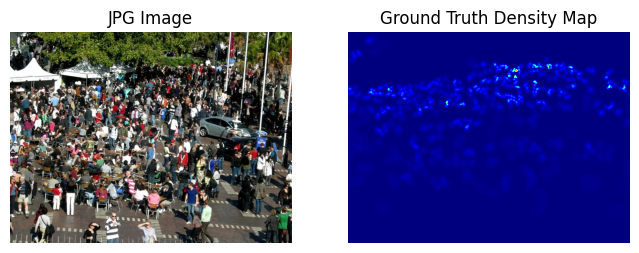

In [22]:
import cv2
import matplotlib.pyplot as plt

train_paths = 'Shanghai Dataset/ShanghaiTech/part_A/test_data/images/IMG_10.jpg'
train_labels = 'Shanghai Dataset/ShanghaiTech/part_A/test_data/ground-truth-h5/IMG_10.h5'

sample_index = 0

jpg_image_path = 'Shanghai Dataset/ShanghaiTech/part_A/test_data/images/IMG_10.jpg'
jpg_image = cv2.imread(jpg_image_path)
jpg_image = cv2.cvtColor(jpg_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(jpg_image)
plt.title('JPG Image')
plt.axis('off')

h5_file_path = 'Shanghai Dataset/ShanghaiTech/part_A/test_data/ground-truth-h5/IMG_10.h5'
ground_truth_density = load_density(h5_file_path)[:, :, 0] 

plt.subplot(1, 2, 2)
plt.imshow(ground_truth_density, cmap='jet')
plt.title('Ground Truth Density Map')
plt.axis('off')

plt.show()

# Data Generator

In [23]:
target_type=tf.dtypes.float16

def load_img(path):
    image_string=tf.io.read_file(path)
    image=tf.image.decode_jpeg(image_string,channels=3)
    image=tf.image.convert_image_dtype(image, target_type)
    return image

def gen_translate_func(translate_range):
    def translate_function(img, gth):
        ratio=tf.random.uniform((2,), minval=translate_range[1], maxval=translate_range[0], dtype=tf.dtypes.int32)
        ratio=tf.cast(ratio, target_type)

        out_gth=tfa.image.translate(gth, ratio, 'BILINEAR')
        out_img=tfa.image.translate(img, ratio, 'BILINEAR')

        return out_img, out_gth
    return translate_function

def gen_downsampling_func(downsampling, method='nearest', batch=True):
    batchadd=1
    if batch==False:
        batchadd=0
    @tf.function
    def _downsampling_function_(img, gth):
        down_ratio=downsampling
        before_resize=tf.reduce_sum(gth)
        gth_shape=tf.shape(gth)
        out_gth=tf.image.resize(gth, (gth_shape[0+batchadd]//down_ratio, gth_shape[1+batchadd]//down_ratio), method=method,antialias=False)
        out_gth=tf.cast(out_gth, dtype=target_type)
        after_resize=tf.reduce_sum(out_gth)
        if (before_resize >= 0.3) and (after_resize > 0.01):
            out_gth=out_gth * before_resize / after_resize
        return img, out_gth
    return _downsampling_function_

def gen_randomcrop_func(crop_size, batch=True):
    batchadd=1
    if batch==False:
        batchadd=0
    @tf.function
    def _random_crop_(img, gth):
        
        output_shape=tf.constant(crop_size)
        img_shape=tf.shape(img)

        ratio_x=tf.random.uniform((1,), minval=0, maxval=img_shape[1+batchadd]-output_shape[1], dtype=tf.dtypes.int32)[0]
        ratio_y=tf.random.uniform((1,), minval=0, maxval=img_shape[0+batchadd]-output_shape[0], dtype=tf.dtypes.int32)[0]

        out_img=tf.image.crop_to_bounding_box(img, ratio_y, ratio_x, output_shape[0], output_shape[1])
        out_gth=tf.image.crop_to_bounding_box(gth, ratio_y, ratio_x, output_shape[0], output_shape[1])

        return out_img, out_gth
    return _random_crop_

def gen_coarsedrop_func(hole_count, hole_size, hole_prob=0.75):
    def _dropout_(image, gth):
        shape = tf.shape(image)
        BATCH = shape[0]
        IMG_WIDTH = shape[2]
        IMG_HEIGHT = shape[1]
        IMG_WIDTH_F = tf.cast(IMG_WIDTH, tf.float32)
        IMG_HEIGHT_F = tf.cast(IMG_HEIGHT, tf.float32)
        PROBABILITY = hole_prob
        CT = hole_count
        CROP_SIZE = tf.cast(hole_size,tf.int32)
        # DO DROPOUT WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([], 0.0, 1.0) < PROBABILITY, tf.int32)
        if (P==0): return image, gth
        
        mask = tf.ones((IMG_HEIGHT,IMG_WIDTH,1))
        for k in range(CT):
            # CHOOSE RANDOM LOCATION
            x = tf.cast( tf.random.uniform([],0.0,IMG_WIDTH_F),tf.int32)
            y = tf.cast( tf.random.uniform([],0.0,IMG_HEIGHT_F),tf.int32)
            # COMPUTE SQUARE
            ya = tf.math.maximum(0,y-CROP_SIZE//2)
            yb = tf.math.minimum(IMG_HEIGHT,y+CROP_SIZE//2)
            xa = tf.math.maximum(0,x-CROP_SIZE//2)
            xb = tf.math.minimum(IMG_WIDTH,x+CROP_SIZE//2)
            # DROPOUT IMAGE
            one = mask[ya:yb,0:xa,:]
            two = tf.zeros([yb-ya,xb-xa,1]) 
            three = mask[ya:yb,xb:IMG_WIDTH,:]
            middle = tf.concat([one,two,three],axis=1)
            mask = tf.concat([mask[0:ya,:,:],middle,mask[yb:IMG_HEIGHT,:,:]],axis=0)
        
        # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR 
        mask = tf.cast(mask, dtype='float16')
        return image*mask, gth*mask
    return _dropout_

def basic_dataset(img_data, label_data=None, batch_size=1, flip=False, downsampling=1, buffer_size=32, shuffle=False):
    input_data=tf.data.Dataset.from_tensor_slices(img_data)
    input_data = input_data.map(load_img)
    output_data=tf.data.Dataset.from_tensor_slices(label_data)

    if flip:
        input_data=input_data.concatenate(input_data.map(tf.image.flip_left_right))
        output_data=output_data.concatenate(output_data.map(tf.image.flip_left_right))

    dataset=tf.data.Dataset.zip((input_data, output_data))
    if shuffle:
        dataset = dataset.batch(batch_size).repeat().shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True)
    else:
        dataset = dataset.batch(batch_size).repeat()

    if downsampling!=1:
        dataset=dataset.map(gen_downsampling_func(downsampling=downsampling))
    return dataset

def crop_dataset(img_data, label_data, crop_size, flip, downsampling, batch_size=1, sample_method='bicubic', buffer_size=16, 
hole_count=0, hole_size=100, hole_prob=0.75):
    dataset = basic_dataset(img_data, label_data, flip=flip, batch_size=batch_size, downsampling=1, shuffle=True, buffer_size=buffer_size)
    dataset=dataset.map(gen_randomcrop_func(crop_size))
    if hole_count!=0:
        dataset=dataset.map(gen_coarsedrop_func(hole_count=hole_count, hole_size=hole_size, hole_prob=hole_prob))
    if downsampling!=1:
        dataset=dataset.map(gen_downsampling_func(downsampling=downsampling, method=sample_method))
    return dataset

def translate_dataset(img_data, label_data, translate_range, flip, downsampling, batch_size=1, sample_method='bicubic', buffer_size=16, 
hole_count=0, hole_size=100, hole_prob=0.75):
    dataset = basic_dataset(img_data, label_data, flip=flip, batch_size=batch_size, downsampling=1, shuffle=True, buffer_size=buffer_size)
    dataset=dataset.map(gen_translate_func(translate_range))
    if hole_count!=0:
        dataset=dataset.map(gen_coarsedrop_func(hole_count=hole_count, hole_size=hole_size, hole_prob=hole_prob))
    if downsampling!=1:
        dataset=dataset.map(gen_downsampling_func(downsampling=downsampling, method=sample_method))
    return dataset
            
def show_images(images, cols = 2, titles = None, padding=1, axis="off", channel1=CM.jet):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    # if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    if titles is None: titles = [None for i in range(1,n_images + 1)]
    fig = plt.figure()
    
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)

        plt.axis(axis)
        plt.subplots_adjust(wspace=padding, hspace=padding)

        if (image.shape[2] == 1):
            image = image[:,:,0]
            plt.imshow(image, cmap=channel1)
        elif np.any(image > 1.0):
            plt.imshow(image / 255.0)
        else:
            plt.imshow(image)
        a.set_title(title, fontsize=20)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

def density_mae(y_truth, y_pred):
    return tf.reduce_mean(tf.abs(tf.reduce_sum(y_truth, axis=(1,2,3))-tf.reduce_sum(y_pred, axis=(1,2,3))))

# CSR-Net

In [24]:
def CSRNet(batch_norm=False, middle_activation='relu', final_activation='sigmoid', reg=(0.0,0.0), normal_input=True, dilations=[2,2,2,2,2,2], dtype=tf.dtypes.float16):
    init=RandomNormal(stddev=0.01)
    
    activationDict = {
        'sigmoid': tf.math.sigmoid,
        'relu': tf.nn.relu,
        'tanh': tf.math.tanh,
        'leakyrelu': tf.nn.leaky_relu,
        'elu': tf.nn.elu,
        'softsign':tf.nn.softsign
    }
    vgg16 = VGG16(weights='imagenet', include_top=False)
    vgg16.trainable=False
    
    input_layer = Input(shape=(None, None, 3))
    x = input_layer
    if (normal_input):
        x = Lambda(lambda batch: (batch - tf.constant([0.485,0.456,0.406], dtype=dtype)) / tf.constant([0.229,0.224,0.225],dtype=dtype))(x)

    count = 0
    for layer in vgg16.layers:
        layer.trainable = False
        x = layer(x)
        if 'conv' in layer.name:
            count+=1
        if count == 10:
            break;
            
    if batch_norm:
        x = BatchNormalization()(x)
    
    if batch_norm:
        x = Conv2D(filters=512, kernel_size=(3, 3), dilation_rate=dilations[0], padding='same', use_bias=False, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
        x = BatchNormalization()(x)
    else:
        x = Conv2D(filters=512, kernel_size=(3, 3), dilation_rate=dilations[0], padding='same', use_bias=True, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
    x = Activation(activationDict[middle_activation])(x)
    
    if batch_norm:
        x = Conv2D(filters=512, kernel_size=(3, 3), dilation_rate=dilations[1], padding='same', use_bias=False, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
        x = BatchNormalization()(x)
    else:
        x = Conv2D(filters=512, kernel_size=(3, 3), dilation_rate=dilations[1], padding='same', use_bias=True, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
    x = Activation(activationDict[middle_activation])(x)
    
    if batch_norm:
        x = Conv2D(filters=512, kernel_size=(3, 3), dilation_rate=dilations[2], padding='same', use_bias=False, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
        x = BatchNormalization()(x)
    else:
        x = Conv2D(filters=512, kernel_size=(3, 3), dilation_rate=dilations[2], padding='same', use_bias=True, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
    x = Activation(activationDict[middle_activation])(x)
    
    if batch_norm:
        x = Conv2D(filters=256, kernel_size=(3, 3), dilation_rate=dilations[3], padding='same', use_bias=False, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
        x = BatchNormalization()(x)
    else:
        x = Conv2D(filters=256, kernel_size=(3, 3), dilation_rate=dilations[3], padding='same', use_bias=True, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
    x = Activation(activationDict[middle_activation])(x)
    
    if batch_norm:
        x = Conv2D(filters=128, kernel_size=(3, 3), dilation_rate=dilations[4], padding='same', use_bias=False, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
        x = BatchNormalization()(x)
    else:
        x = Conv2D(filters=128, kernel_size=(3, 3), dilation_rate=dilations[4], padding='same', use_bias=True, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
    x = Activation(activationDict[middle_activation])(x)
    
    if batch_norm:
        x = Conv2D(filters=64, kernel_size=(3, 3), dilation_rate=dilations[5], padding='same', use_bias=False, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
        x = BatchNormalization()(x)
    else:
        x = Conv2D(filters=64, kernel_size=(3, 3), dilation_rate=dilations[5], padding='same', use_bias=True, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
    x = Activation(activationDict[middle_activation])(x)
        
    ###############################    
    x = Conv2D(filters=1, kernel_size=(1, 1), dilation_rate=1, padding='same', use_bias=True, kernel_initializer=init)(x)
    x = Activation(activationDict[final_activation])(x)
    
    model = Model(input_layer, x)
    
    return model

# Augmentation: flip + translate (translate => random crop with big size)

In [25]:
sgd = SGD(lr = 1e-4, momentum = 0.7, nesterov=True)
rms = RMSprop(lr=1e-4, momentum=0.7, decay=0.0001)
nadam = Nadam(lr=1e-2)

optimizer = rms
loss = 'binary_crossentropy'

batch_size=8
train_size=320

val_gen = basic_dataset(train_paths[train_size:], train_labels[train_size:], batch_size=1, flip=False, downsampling=8, buffer_size=16, shuffle=False)
test_gen = basic_dataset(test_paths, test_labels, batch_size=1, flip=False, downsampling=8, buffer_size=16, shuffle=False)
train_gen  = crop_dataset(train_paths[:train_size], train_labels[:train_size], crop_size=(760,1000), flip=True, downsampling=8, batch_size=batch_size, sample_method='bicubic', buffer_size=8)

filepath = r'/kaggle/input/masjidil-haram/CSRNet_1.h5'
reduceLR=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_density_mae', factor=0.5, patience=5, verbose=1, min_delta=1e-8)
earlyStop=tf.keras.callbacks.EarlyStopping(monitor='val_density_mae', patience=25, verbose=1, restore_best_weights=True)
monitor=tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_density_mae', verbose=0, save_best_only=True, save_weights_only=True)

ValueError: Value tf.Tensor(b'', shape=(), dtype=string) has insufficient rank for batching.

In [ ]:
model = CSRNet(middle_activation='relu', final_activation='sigmoid', dtype=tf.dtypes.float16)
model.compile(optimizer=optimizer, loss=loss, metrics=[density_mae])
model.build(input_shape=(None, None, None, 3))

print('train baseline: ', np.mean( np.sum(train_labels[:train_size], axis=(1,2,3))))
print('val baseline: ', np.mean( np.sum(train_labels[320:], axis=(1,2,3))))

#model.fit(train_gen, steps_per_epoch=int(train_size*2/batch_size), epochs=80, verbose=1, use_multiprocessing=True,
#              max_queue_size=32, workers=6, validation_data=val_gen, validation_steps=80, callbacks=[earlyStop, monitor, reduceLR])

model.load_weights(filepath)
model.evaluate(val_gen, steps=80, verbose=1, workers=4)
model.evaluate(test_gen, steps=316, verbose=1, workers=4)

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



AxisError: axis 1 is out of bounds for array of dimension 0

In [ ]:
for a,b in test_gen.take(10):
    c = model.predict(a)
    a = tf.cast(a, dtype=tf.dtypes.float32)
    b = tf.cast(b, dtype=tf.dtypes.float32)
    c = c.astype('float32')
    show_images([a[0], b[0], c[0]], 1, ['', np.sum(b[0]), np.sum(c[0])])

NameError: name 'test_gen' is not defined

In [ ]:
def basic_dataset_unlabeled(img_data, batch_size):
    input_data = tf.data.Dataset.from_tensor_slices(img_data)
    input_data = input_data.map(load_img)  

    #if flip:
     #   input_data = input_data.concatenate(input_data.map(tf.image.flip_left_right))

    #if downsampling > 1:
       # input_data = input_data.map(lambda img: tf.image.resize(img, (img.shape[0] // downsampling, img.shape[1] // downsampling)))

   # if shuffle:
    #    input_data = input_data.shuffle(buffer_size=buffer_size)

    dataset = input_data.batch(batch_size).repeat()

    return dataset

In [ ]:
show_images([c[0]], 1, [np.sum(c[0])])

In [ ]:
def basic_dataset_unlabeled(img_data, batch_size):
    input_data = tf.data.Dataset.from_tensor_slices(img_data)
    input_data = input_data.map(load_img)

    dataset = input_data.batch(batch_size)

    return dataset


img_name = "crowd2.png"
img_path = ["/kaggle/input/test-image/" + img_name]

target_height, target_width = (768, 1024)
test_img = basic_dataset_unlabeled(img_path, batch_size=1)

h = model.predict(test_img, steps=len(img_path))

h = h.astype('float32')
count = np.sum(h[0])
count = count.astype("float32")

fig = plt.figure(figsize=(10, 6))
test_img = cv2.imread(img_path[0])
test_img = test_img.astype(np.uint8)
plt.imshow(test_img)
plt.title(f"Predicted Count: {count}")
plt.show()


In [ ]:
def basic_dataset_unlabeled(img_data, batch_size):
    input_data = tf.data.Dataset.from_tensor_slices(img_data)
    input_data = input_data.map(load_img)

    dataset = input_data.batch(batch_size)

    return dataset

img_name = "/mh2.jpg"
img_path = ["/kaggle/input/masjidil-haram" + img_name]

target_height, target_width = (768, 1024)
test_img = basic_dataset_unlabeled(img_path, batch_size=1)

# Predict the heatmap using the model
predicted_heatmap = model.predict(test_img, steps=len(img_path))

# Convert data types for visualization
predicted_heatmap = predicted_heatmap.astype('float32')
count = np.sum(predicted_heatmap[0])
count = count.astype("float32")

# Load and display the original image
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Display original image
test_img = cv2.imread(img_path[0])
test_img = test_img.astype(np.uint8)
axs[0].imshow(test_img)
axs[0].set_title("Input Image")

# Display heatmap
axs[1].imshow(predicted_heatmap[0, :, :, 0], cmap=CM.jet)
axs[1].set_title(f"Heatmap - Predicted Count: {count}")

plt.show()

## Testing Code

In [27]:
sgd = SGD(lr = 1e-4, momentum = 0.7, nesterov=True)
rms = RMSprop(lr=1e-4, momentum=0.7, decay=0.0001)
nadam = Nadam(lr=1e-2)

optimizer = rms
loss = 'binary_crossentropy'

batch_size=8
train_size=320

#val_gen = basic_dataset(train_paths[train_size:], train_labels[train_size:], batch_size=1, flip=False, downsampling=8, buffer_size=16, shuffle=False)
#test_gen = basic_dataset(test_paths, test_labels, batch_size=1, flip=False, downsampling=8, buffer_size=16, shuffle=False)
#train_gen  = crop_dataset(train_paths[:train_size], train_labels[:train_size], crop_size=(760,1000), flip=True, downsampling=8, batch_size=batch_size, sample_method='bicubic', buffer_size=8)

filepath = r'CSRNet_1.h5'
reduceLR=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_density_mae', factor=0.5, patience=5, verbose=1, min_delta=1e-8)
earlyStop=tf.keras.callbacks.EarlyStopping(monitor='val_density_mae', patience=25, verbose=1, restore_best_weights=True)
monitor=tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_density_mae', verbose=0, save_best_only=True, save_weights_only=True)

In [28]:
def CSRNet(batch_norm=False, middle_activation='relu', final_activation='sigmoid', reg=(0.0,0.0), normal_input=True, dilations=[2,2,2,2,2,2], dtype=tf.dtypes.float16):
    init=RandomNormal(stddev=0.01)
    
    activationDict = {
        'sigmoid': tf.math.sigmoid,
        'relu': tf.nn.relu,
        'tanh': tf.math.tanh,
        'leakyrelu': tf.nn.leaky_relu,
        'elu': tf.nn.elu,
        'softsign':tf.nn.softsign
    }
    vgg16 = VGG16(weights='imagenet', include_top=False)
    vgg16.trainable=False
    
    input_layer = Input(shape=(None, None, 3))
    x = input_layer
    if (normal_input):
        x = Lambda(lambda batch: (batch - tf.constant([0.485,0.456,0.406], dtype=dtype)) / tf.constant([0.229,0.224,0.225],dtype=dtype))(x)

    count = 0
    for layer in vgg16.layers:
        layer.trainable = False
        x = layer(x)
        if 'conv' in layer.name:
            count+=1
        if count == 10:
            break;
            
    if batch_norm:
        x = BatchNormalization()(x)
    
    if batch_norm:
        x = Conv2D(filters=512, kernel_size=(3, 3), dilation_rate=dilations[0], padding='same', use_bias=False, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
        x = BatchNormalization()(x)
    else:
        x = Conv2D(filters=512, kernel_size=(3, 3), dilation_rate=dilations[0], padding='same', use_bias=True, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
    x = Activation(activationDict[middle_activation])(x)
    
    if batch_norm:
        x = Conv2D(filters=512, kernel_size=(3, 3), dilation_rate=dilations[1], padding='same', use_bias=False, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
        x = BatchNormalization()(x)
    else:
        x = Conv2D(filters=512, kernel_size=(3, 3), dilation_rate=dilations[1], padding='same', use_bias=True, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
    x = Activation(activationDict[middle_activation])(x)
    
    if batch_norm:
        x = Conv2D(filters=512, kernel_size=(3, 3), dilation_rate=dilations[2], padding='same', use_bias=False, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
        x = BatchNormalization()(x)
    else:
        x = Conv2D(filters=512, kernel_size=(3, 3), dilation_rate=dilations[2], padding='same', use_bias=True, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
    x = Activation(activationDict[middle_activation])(x)
    
    if batch_norm:
        x = Conv2D(filters=256, kernel_size=(3, 3), dilation_rate=dilations[3], padding='same', use_bias=False, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
        x = BatchNormalization()(x)
    else:
        x = Conv2D(filters=256, kernel_size=(3, 3), dilation_rate=dilations[3], padding='same', use_bias=True, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
    x = Activation(activationDict[middle_activation])(x)
    
    if batch_norm:
        x = Conv2D(filters=128, kernel_size=(3, 3), dilation_rate=dilations[4], padding='same', use_bias=False, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
        x = BatchNormalization()(x)
    else:
        x = Conv2D(filters=128, kernel_size=(3, 3), dilation_rate=dilations[4], padding='same', use_bias=True, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
    x = Activation(activationDict[middle_activation])(x)
    
    if batch_norm:
        x = Conv2D(filters=64, kernel_size=(3, 3), dilation_rate=dilations[5], padding='same', use_bias=False, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
        x = BatchNormalization()(x)
    else:
        x = Conv2D(filters=64, kernel_size=(3, 3), dilation_rate=dilations[5], padding='same', use_bias=True, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
    x = Activation(activationDict[middle_activation])(x)
        
    ###############################    
    x = Conv2D(filters=1, kernel_size=(1, 1), dilation_rate=1, padding='same', use_bias=True, kernel_initializer=init)(x)
    x = Activation(activationDict[final_activation])(x)
    
    model = Model(input_layer, x)
    return model

In [29]:
model = CSRNet(middle_activation='relu', final_activation='sigmoid', dtype=tf.dtypes.float16)
model.compile(optimizer=optimizer, loss=loss, metrics=[density_mae])
model.build(input_shape=(None, None, None, 3))

#print('train baseline: ', np.mean( np.sum(train_labels[:train_size], axis=(1,2,3))))
#print('val baseline: ', np.mean( np.sum(train_labels[320:], axis=(1,2,3))))

model.load_weights(filepath)
#model.evaluate(val_gen, steps=80, verbose=1, workers=4)
#model.evaluate(test_gen, steps=316, verbose=1, workers=4)

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



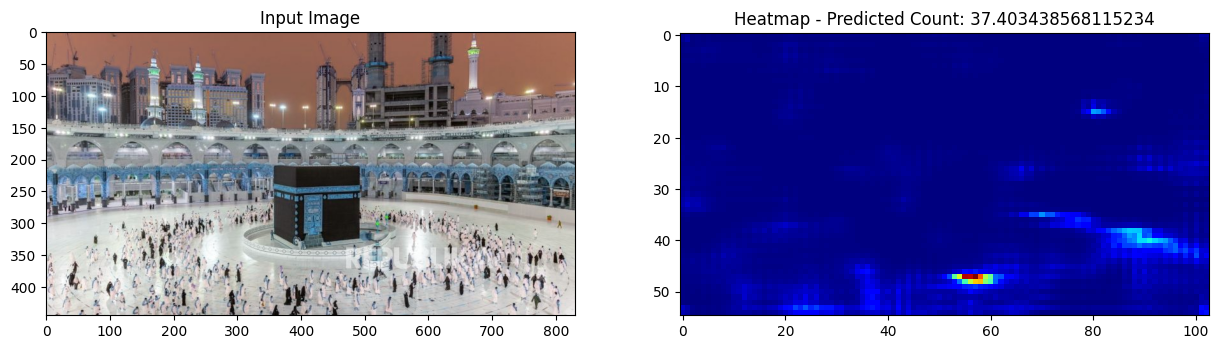

In [30]:
def basic_dataset_unlabeled(img_data, batch_size):
    input_data = tf.data.Dataset.from_tensor_slices(img_data)
    input_data = input_data.map(load_img)

    dataset = input_data.batch(batch_size)
    return dataset

img_name = "mh1.jpg"
img_path = ["foto masjidil haram/" + img_name]

target_height, target_width = (768, 1024)
test_img = basic_dataset_unlabeled(img_path, batch_size=1)

# Predict the heatmap using the model
predicted_heatmap = model.predict(test_img, steps=len(img_path))

# Convert data types for visualization
predicted_heatmap = predicted_heatmap.astype('float32')
count = np.sum(predicted_heatmap[0])
count = count.astype("float32")

# Load and display the original image
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Display original image
test_img = cv2.imread(img_path[0])
test_img = test_img.astype(np.uint8)
axs[0].imshow(test_img)
axs[0].set_title("Input Image")

# Display heatmap
axs[1].imshow(predicted_heatmap[0, :, :, 0], cmap=CM.jet)
axs[1].set_title(f"Heatmap - Predicted Count: {count}")

plt.show()

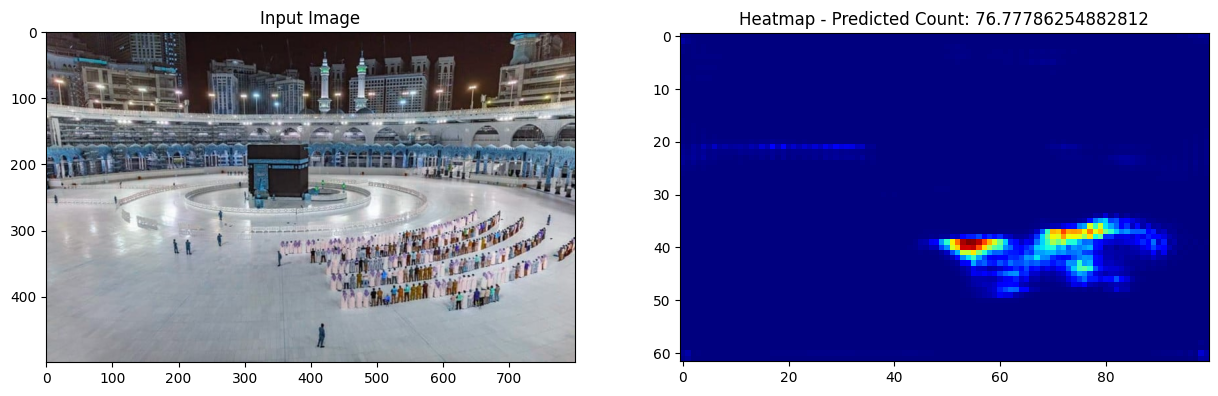

In [32]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

def basic_dataset_unlabeled(img_data, batch_size):
    input_data = tf.data.Dataset.from_tensor_slices(img_data)
    input_data = input_data.map(load_img)
    dataset = input_data.batch(batch_size)
    return dataset

def visualize_heatmap(img_path, model):
    # Load and preprocess the image
    test_img = basic_dataset_unlabeled(img_path, batch_size=1)

    # Predict the heatmap using the model
    predicted_heatmap = model.predict(test_img, steps=len(img_path))

    # Convert data types for visualization
    predicted_heatmap = predicted_heatmap.astype('float32')
    count = np.sum(predicted_heatmap[0]).astype("float32")

    # Load and display the original image
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # Display original image
    test_img = cv2.imread(img_path[0])
    test_img = test_img.astype(np.uint8)
    axs[0].imshow(test_img)
    axs[0].set_title("Input Image")

    # Display heatmap
    axs[1].imshow(predicted_heatmap[0, :, :, 0], cmap=plt.cm.jet)
    axs[1].set_title(f"Heatmap - Predicted Count: {count}")

    plt.show()

# Example usage
img_name = "mh2.jpg"
img_path = ["foto masjidil haram/" + img_name]

visualize_heatmap(img_path, model)

In [33]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imshow

def extract_display_frames(video_path):
    # Load video
    video = cv2.VideoCapture(video_path)
    # Loop all frames
    frames = []
    i=0
    while(video.isOpened()):
        ret, frame = video.read()
        i+=1
        if ret == False:            
            break
        
        #cv2.imshow("Video", frame)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        cv2.waitKey(40) #40ms => 25 frames/s
        frames.append(frame)
    video.release()
    cv2.destroyAllWindows()
    
    print(f'jumlah frame {i}')
    # return as numpy array
    return np.array(frames) 

frames=extract_display_frames('foto masjidil haram/masjidil haram 2.mp4')


jumlah frame 366


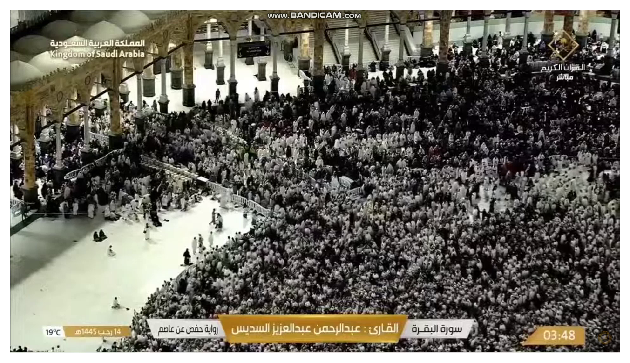

In [34]:
image_x = 9 #Ambil frame nomor 1 misalkan
image_1 = frames[image_x]

plt.axis("off")
imshow(image_1)

plt.show()

### Extract semua frame dalam file jpg

In [ ]:
import cv2 
import numpy as np
import os

def extract_save_frames(video_path):
    # Membuat folder baru untuk menyimpan frame
    folder_name = 'extracted_frame'
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # Load video
    video = cv2.VideoCapture(video_path)
    # Loop semua frame
    frames = []
    i = 0
    j = 0
    while(video.isOpened()):
        ret, frame = video.read()
        i += 1
        if ret == False:            
            break
        
        # Menyimpan frame setiap 10 frame
        if i % 5 == 0:
            cv2.imwrite(f'{folder_name}/frame_{j}.jpg', frame)
            j += 1
        
        frames.append(frame)

    video.release()
    cv2.destroyAllWindows()
    
    print(f'Jumlah frame: {i}')
    print(f'Jumlah frame yang disimpan: {j}')
    # Mengembalikan sebagai array numpy
    return np.array(frames) 

frames = extract_save_frames('foto masjidil haram/masjidil haram 2.mp4')

Jumlah frame: 366
Jumlah frame yang disimpan: 73


In [35]:
import os
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_img(img_path):
    # Load and preprocess the image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))  # Adjust the size as needed
    img = tf.expand_dims(img, 0)
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img

def basic_dataset_labeled(img_paths, batch_size):
    input_data = tf.data.Dataset.from_tensor_slices(img_paths)
    input_data = input_data.map(load_img)
    dataset = input_data.batch(batch_size)
    return dataset

def visualize_and_save_heatmap(img_folder, output_folder, model):
    # Get all image file paths in the specified folder
    img_paths = [os.path.join(img_folder, img_name) for img_name in os.listdir(img_folder) if img_name.endswith(('.jpg', '.jpeg'))]

    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Predict and save heatmaps for each image
    for img_path in img_paths:
        # Load and preprocess the image
        test_img = load_img(img_path)

        # Predict the heatmap using the model
        predicted_heatmap = model.predict(test_img)

        # Convert data types for visualization
        predicted_heatmap = predicted_heatmap.astype('float32')
        count = np.sum(predicted_heatmap[0]).astype("float32")

        # Display and save heatmap
        plt.figure(figsize=(18, 14))
        plt.imshow(predicted_heatmap[0, :, :, 0], cmap=plt.cm.jet)
        plt.title(f"Heatmap - Predicted Count: {count}")
        plt.savefig(os.path.join(output_folder, os.path.basename(img_path).replace('.jpg', '_heatmap.png')), dpi=300)
        plt.close()

# Example usage
img_folder = "extracted_frame"
output_folder = "predicted"

# Assuming the model is loaded and ready for inference
visualize_and_save_heatmap(img_folder, output_folder, model)

In [36]:
import os
from PIL import Image

output_folder = "extracted_frame"

# Get the list of PNG files in the output folder
png_files = [file for file in os.listdir(output_folder) if file.endswith('.jpg')]

# Sort the PNG files in ascending order
png_files.sort()

# Create a list to store the image frames
image_frames = []

# Open each PNG file and add it to the image frames list
for png_file in png_files:
    image = Image.open(os.path.join(output_folder, png_file))
    image_frames.append(image)

# Save the image frames as a GIF
output_path = os.path.join(output_folder, "output frame.gif")
image_frames[0].save(output_path, save_all=True, append_images=image_frames[1:], loop=0, duration=200)

print("GIF conversion complete!")

GIF conversion complete!


### Proses untuk satu layar saja

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

def basic_dataset_unlabeled(img_data, batch_size):
    input_data = tf.data.Dataset.from_tensor_slices(img_data)
    input_data = input_data.map(load_img)
    dataset = input_data.batch(batch_size)
    return dataset

def visualize_heatmap(img_path, model):
    # Load and preprocess the image
    test_img = basic_dataset_unlabeled(img_path, batch_size=1)

    # Predict the heatmap using the model
    predicted_heatmap = model.predict(test_img, steps=len(img_path))

    # Convert data types for visualization
    predicted_heatmap = predicted_heatmap.astype('float32')
    count = np.sum(predicted_heatmap[0]).astype("float32")

    # Display heatmap only
    plt.figure(figsize=(18, 14))  # Ukuran plot yang lebih besar
    plt.imshow(predicted_heatmap[0, :, :, 0], cmap=plt.cm.jet)
    plt.title(f"Heatmap - Predicted Count: {count}")
    # plt.colorbar()
    plt.savefig("predicted_heatmap.png", dpi=300)
    plt.show()

# Example usage
img_name = "mh5.png"
img_path = ["foto masjidil haram/" + img_name]

# Assuming the model is loaded and ready for inference
visualize_heatmap(img_path, model)

FileNotFoundError: [WinError 206] The filename or extension is too long: 'c:\\python\\lib\\site-packages\\pandas.libs'

In [ ]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imshow

def extract_display_frames(video_path, output_path=None, frame_number=0):
    # Load video
    video = cv2.VideoCapture(video_path)
    # Loop all frames
    frames = []
    i = 0
    while(video.isOpened()):
        ret, frame = video.read()
        i += 1
        if ret == False:            
            break
        
        # cv2.imshow("Video", frame)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        cv2.waitKey(40) # 40ms => 25 frames/s
        frames.append(frame)
    video.release()
    cv2.destroyAllWindows()
    
    print(f'jumlah frame {i}')
    
    # Convert frames to numpy array
    frames_array = np.array(frames)
    
    if output_path is not None:
        # Display and save the specified frame as PNG
        plt.axis("off")
        imshow(frames_array[frame_number])
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
        plt.close()  # Close the figure to avoid displaying the image again
    
    # return as numpy array
    return [output_path]

jumlah frame 366


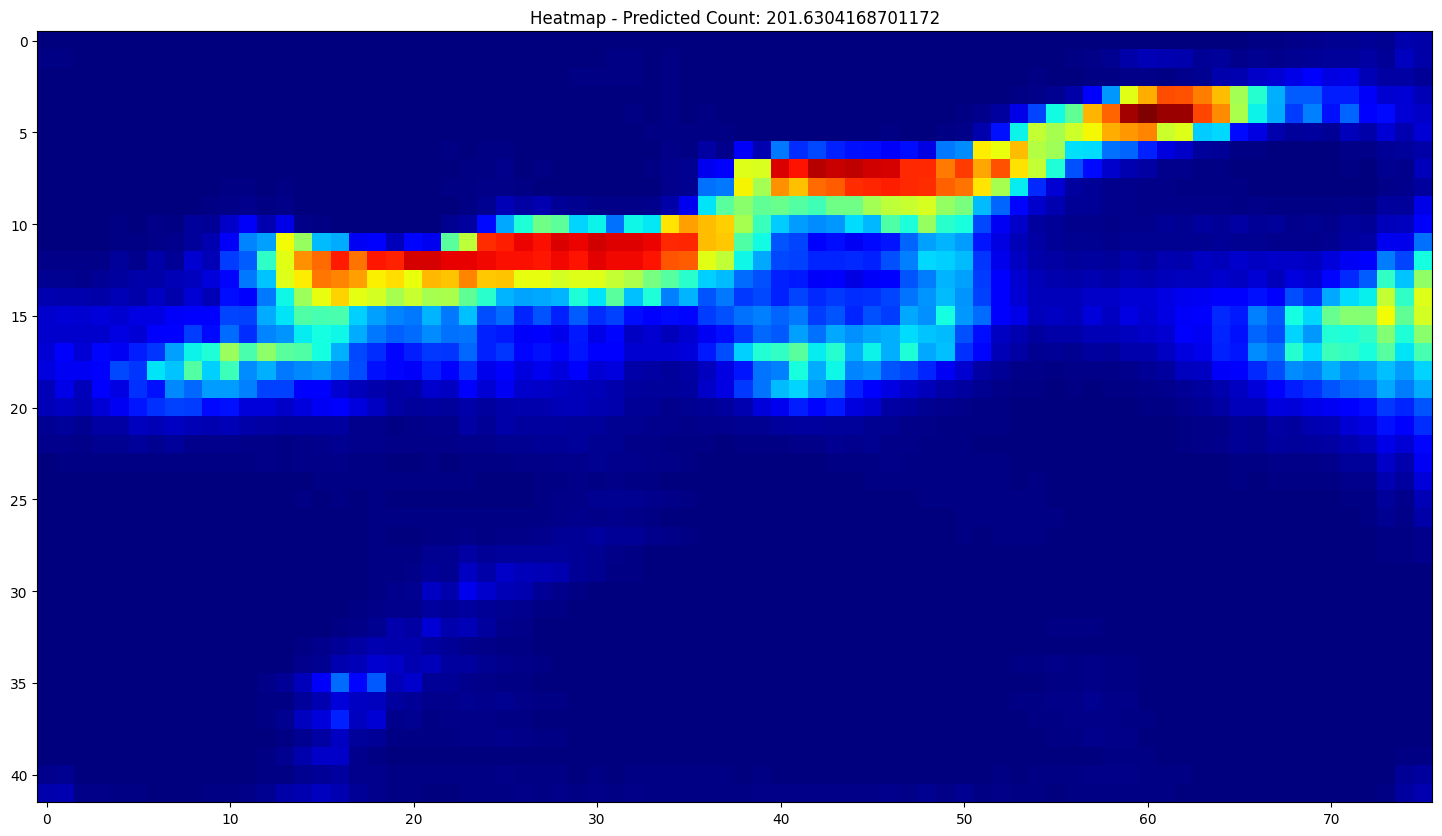

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

def basic_dataset_unlabeled(img_data, batch_size):
    input_data = tf.data.Dataset.from_tensor_slices(img_data)
    input_data = input_data.map(load_img)
    dataset = input_data.batch(batch_size)
    return dataset

def visualize_heatmap(img_path, model):
    # Load and preprocess the image
    test_img = basic_dataset_unlabeled(img_path, batch_size=1)

    # Predict the heatmap using the model
    predicted_heatmap = model.predict(test_img, steps=len(img_path))

    # Convert data types for visualization
    predicted_heatmap = predicted_heatmap.astype('float32')
    count = np.sum(predicted_heatmap[0]).astype("float32")

    # Display heatmap only
    plt.figure(figsize=(18, 14))  # Ukuran plot yang lebih besar
    plt.imshow(predicted_heatmap[0, :, :, 0], cmap=plt.cm.jet)
    plt.title(f"Heatmap - Predicted Count: {count}")
    #plt.colorbar()
    plt.show()

# Set the output path
output_path = 'output_image.png'
desired_frame_number = 159
frames = extract_display_frames('foto masjidil haram/masjidil haram 2.mp4', output_path, desired_frame_number)

visualize_heatmap(frames, model)

jumlah frame 366


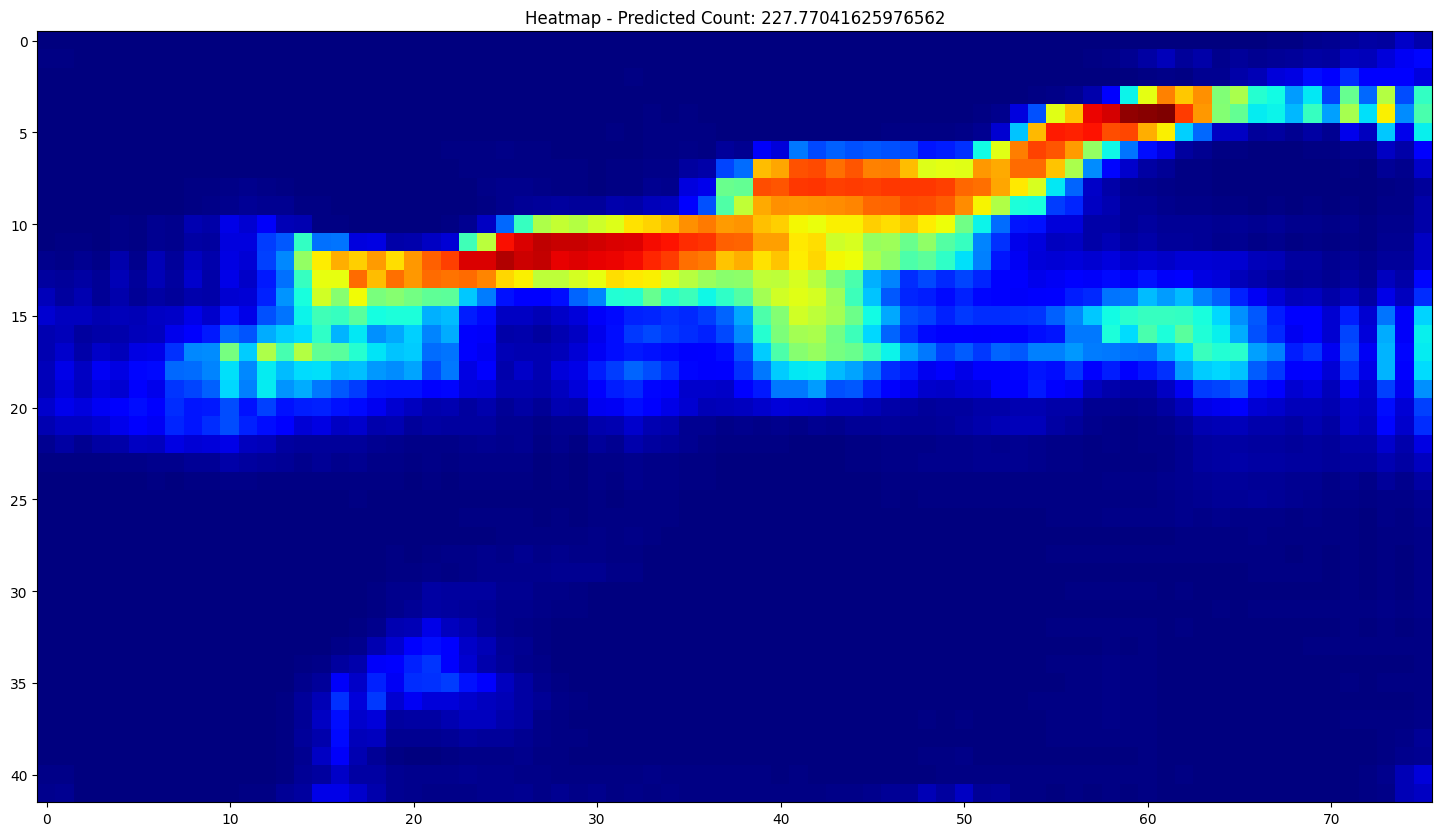

In [ ]:
# Iterate over frames 1 to 15
for frame_number in range(1, 2):
    frames = extract_display_frames('foto masjidil haram/masjidil haram 2.mp4', output_path, frame_number)
    
    # Placeholder call to visualize_heatmap, replace with actual implementation
    visualize_heatmap(frames, model)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imshow
import tensorflow as tf
import imageio
from IPython.display import display, Image

# Extract frames
output_path = '/kaggle/working/output_image.png'  # Change the output path as needed
desired_frame_number = 159
frames = extract_display_frames('/kaggle/input/masjidil-haram/masjidil haram 2.mp4', output_path, desired_frame_number)

# Visualize and save frames as images
for frame_number in range(1, 3):
    current_frames = extract_display_frames('/kaggle/input/masjidil-haram/masjidil haram 2.mp4', output_path, frame_number)
    modified_frames = visualize_heatmap(current_frames, model)
    imageio.mimsave(gif_path, modified_frames, duration=0.1)

# Display the GIF
display(Image(filename=gif_path))